## Introduction to the COVID-19 Open Research Dataset

The COVID-19 Open Research Dataset (CORD-19) is a collection of over 50,000 scholarly articles - including over 40,000 with full text - about COVID-19, SARS-CoV-2, and related coronaviruses. This dataset has been made freely available with the goal to aid research communities combat the COVID-19 pandemic. It has been made available by the Allen Institute for AI in partnership with leading research groups to prepare and distribute the COVID-19 Open Research Dataset (CORD-19), in response to the COVID-19 pandemic.

During this lab you will learn how to process and analyze a subset of the articles present in the dataset, group them together into a series of clusters, and use Automated ML to train a machine learning model capable of classifying new articles as they are published.

### Setup

We will start off by installing a few packages, such as `nltk` for text processing and `wordcloud`, `seaborn`, and `yellowbrick` for various visualizations.

In [1]:
!pip install nltk
!pip install wordcloud
!pip install seaborn
!pip install yellowbrick

We'll first download stopwords and the Punkt tokenizer models present in the `nltk` package, in order to be able to process the articles

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We'll also import the rest of the modules needed in this notebook, and do a quick sanity-check on the Azure ML SDK version

In [3]:
import os
import json
from string import punctuation

import pandas as pd
import seaborn as sns
sns.set_palette('Set2')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, Birch, AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, PorterStemmer

from azureml.core import Workspace, Datastore, Dataset, VERSION

import azureml.core
from azureml.core import Dataset, Workspace, Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.widgets import RunDetails
from azureml.automl.core.featurization.featurizationconfig import FeaturizationConfig

print("Azure ML SDK Version: ", VERSION)

Azure ML SDK Version:  1.48.0


## Load the Covid-19 data

CORD-19 has been uploaded as an Azure Open Dataset, we will connect to it and use it's API to download the dataset locally.

In [4]:
covid_dirname = 'opendata'

cord19_dataset = Dataset.File.from_files('https://stgai2023.blob.core.windows.net/' + covid_dirname)
mount = cord19_dataset.mount()

covid_dirpath = os.path.join(mount.mount_point, covid_dirname)

Not mounting as a volume: No datastore info was found, volume mount would not be attempted.. 
Falling back to dataflow mount.


Display a sample of the dataset (top 5 rows).

In [5]:
mount.start()

# Load metadata.csv, as it contains a list of all the articles and their corresponding titles/authors/contents.
metadata_filename = os.path.join(covid_dirpath, 'metadata.csv')

metadata = pd.read_csv(metadata_filename)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3194: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Some of the articles do not have any associated documents, so we will filter those out.

In [6]:
metadata_with_docs = metadata[metadata['pdf_json_files'].isna() == False]

print(f'Dataset contains {metadata.shape[0]} entries, out of which {metadata_with_docs.shape[0]} have associated json documents')

Dataset contains 1056660 entries, out of which 373766 have associated json documents


Display the percentage of items in the dataset that have associated JSON documents (research papers that have extra metadata associated with them).

In [7]:
# Change the document index in order to preview a different article
DOCUMENT_INDEX = 0 
example_entry = metadata_with_docs.iloc[DOCUMENT_INDEX]

filepath = os.path.join(covid_dirpath, example_entry['pdf_json_files'])
print(f'Document local filepath: {filepath}')

Document local filepath: /tmp/tmpyzqwk2fb/opendata/document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json


Next, we will display the list of elements that are available for the selected document.

In [8]:
try:
    with open(filepath, 'r') as f:
        data = json.load(f)
        
except FileNotFoundError as e:
    # in case the mount context has been closed
    mount.start()
    with open(filepath, 'r') as f:
        data = json.load(f)
        
print(f'Data elements: { ", ".join(data.keys())}' )

Data elements: paper_id, metadata, abstract, body_text, bib_entries, ref_entries, back_matter


View the full text version of the document.

In [9]:
stop_tokens = nltk.corpus.stopwords.words('english') + list(punctuation) + ['et', 'al.']

In [10]:
class Reader:
    """Class used to read the files associated with an article"""
    
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    
    def read_file_to_json(self, filepath):
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
        except FileNotFoundError as e:
            mount.start()
            with open(filepath, 'r') as f:
                data = json.load(f)
                
        return data
    
    def parse_document(self, document_index):
        document = metadata_with_docs.iloc[document_index]
        
        # One article can have multiple associated documents
        words = []
        for filename in document['pdf_json_files'].split('; '):
            filepath = '{0}/{1}'.format(covid_dirpath, filename)
            data = self.read_file_to_json(filepath)

            # Split each paragraph into multiple sentences first, in order to improve the performance of the word tokenizer
            text = data['body_text']
            for paragraph in text:
                p_sentences = sent_tokenize(paragraph['text'])

                # Split each sentence into words, while making sure to remove the stopwords and stem the words
                for p_sentence in p_sentences:
                    sentence = [ self.stemmer.stem(word) for word in word_tokenize(p_sentence) if word.isalpha() and word.lower() not in stop_tokens ]
                    words.extend(sentence)
    
        return (words, document['cord_uid'])
        

class Corpus:
    """An iterator that reads all sentences from the first N documents"""
    
    def __init__(self, n_documents):
        self.n_documents = n_documents
        self.stemmer = SnowballStemmer('english')
        self.reader = Reader()
        
    def __iter__(self):
         for document_index in range(0, self.n_documents):   
            words, document_id = self.reader.parse_document(document_index)
            yield TaggedDocument(words, document_id)
            
    def plain_iter(self):
        for document_index in range(0, self.n_documents):  
            words, document_id = self.reader.parse_document(document_index)
            yield (words, document_id)

## Encoding documents as vectors

In this lab, we're using a subset of 500 articles to train a Machine Learning model that encodes text documents into numerical vectors (a document embedding model). 

Training a document embedding model takes a significant amount of time, and for this reason we already provide a trained model. We also provide the code below in case you want to get more details about the process. Running the next two cells will result in loading the already existing model.

In [11]:
N_DOCUMENTS = 500

In [12]:
%%time

model_filename = f'covid_embeddings_model_{N_DOCUMENTS}_docs.w2v'

if (os.path.exists(model_filename)):
    model = Doc2Vec.load(model_filename)
    print(f'Done, loaded word2vec model with { len(model.wv.vocab) } words.')
else:
    model = Doc2Vec(Corpus(N_DOCUMENTS), vector_size=128, batch_words=10)
    model.save(model_filename)
    print(f'Done, trained word2vec model with { len(model.wv.vocab) } words.')

Done, trained word2vec model with 12788 words.
CPU times: user 5min 16s, sys: 979 ms, total: 5min 17s
Wall time: 5min 41s


## Word frequencies

Let's analyze the relative frequencies of words in the corpus of articles. We will display a word cloud to provide a visual representation of these relative frequencies.

In [13]:
%%time

word_vectors = []
ids = []

for (words, doc_id) in Corpus(N_DOCUMENTS).plain_iter():
    ids.append(doc_id)
    word_vector = model.infer_vector(words)
    word_vectors.append(word_vector)
    if len(word_vectors) % 100 == 0:
        print(f'Processed {len(word_vectors)} documents.')

Processed 100 documents.
Processed 200 documents.
Processed 300 documents.
Processed 400 documents.
Processed 500 documents.
CPU times: user 58.9 s, sys: 111 ms, total: 59 s
Wall time: 59.7 s


Now that we've finished reading the articles, we can dismount the dataset in order to free up resources

In [14]:
mount.stop()

In [15]:
wv_df = pd.DataFrame(word_vectors, index=ids)

We'll join the DataFrame containing the numerical embeddings with the original dataset.

In [16]:
indexed_metadata = metadata_with_docs.set_index('cord_uid')
metadata_with_embeddings = pd.concat([indexed_metadata.iloc[:N_DOCUMENTS], wv_df], axis=1)

## Clustering documents

We've determined the acceptable value for the clusters, so let's use Machine Learning to determine those clusters. We'll use the classic KMeans algorithm to do this.

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/ana

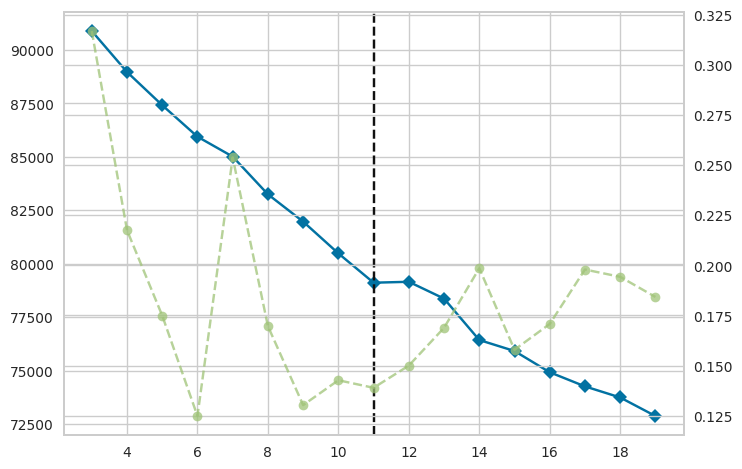

In [17]:
visualizer = KElbowVisualizer(KMeans(), k=(3,20))
visualizer.fit(wv_df)
clusterer = KMeans(12 if visualizer.elbow_value_ > 12 else visualizer.elbow_value_)
clusterer.fit(wv_df)
clusters = clusterer.labels_

We'll add each article's cluster as new column to our combined dataset

In [18]:
metadata_with_clusters = metadata_with_embeddings
metadata_with_clusters['cluster'] = clusters
metadata_with_clusters

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,119,120,121,122,123,124,125,126,127,cluster
cord_uid,,,,,,,,,,,,,,,,,,,,,
ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",...,0.349568,0.286350,0.161049,0.587505,1.266977,-0.534034,-0.334708,-0.059299,0.235618,3
02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",...,0.333666,0.029130,-0.004117,0.863862,0.771726,1.040662,-0.518073,1.333484,0.868478,3
ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",...,-0.678254,0.043507,1.027341,0.868619,2.163687,0.557132,-1.250222,0.285514,2.673776,2
2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",...,-0.115347,0.707596,1.307605,-0.561284,3.748788,-1.567740,-2.447715,0.697329,2.201251,2
9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",...,0.187156,-0.072741,1.139568,0.147747,1.851532,-1.293490,0.020387,0.411341,0.628136,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn1a7ikq,bb3716d66667c66f6f79b37c765388cd334f2cad,PMC,Tylosema esculentum (Marama) Tuber and Bean Ex...,10.1155/2011/284795,PMC3057194,21423688,cc-by,Tylosema esculentum (marama) beans and tubers ...,2011-02-20,"Chingwaru, Walter; Majinda, Runner T.; Yeboah,...",...,-0.290292,2.491299,2.325556,-1.801212,1.774066,-0.457809,-2.347614,-0.815238,-1.307206,0
0gt21051,c44a9d064faca56bd284971828e4db13e656365c; 4040...,PMC,Autonomous Targeting of Infectious Superspread...,10.1371/journal.pcbi.1002015,PMC3060167,21483468,cc-by,"Infectious disease treatments, both pharmaceut...",2011-03-17,"Metzger, Vincent T.; Lloyd-Smith, James O.; We...",...,-3.174060,-0.914619,-0.306507,-0.760139,1.049029,-0.264728,1.728676,-0.858058,2.140322,3
d3a06n3f,6efeb37a50a81c7769a49bcf030e54b148bd1fbd,PMC,Screening of Random Peptide Library of Hemaggl...,10.1371/journal.pone.0018016,PMC3060926,21437206,cc-by,The antigenic structure of the membrane protei...,2011-03-18,"Xu, Wanghui; Han, Lu; Lin, Zhanglin",...,0.580137,-1.411255,-1.376064,-1.119249,0.840659,-1.027522,-1.687285,1.751633,1.313815,3


We can now split our data into two datasets - a **training** one that will be used to train a Machine Learning model, able to determine the cluster that should be assigned to an article, and a **test** one that we'll use to test this classifier.

We will allocate 80% of the articles to training the Machine Learning model, and the remaining 20% to testing it.

In [19]:
train, test = train_test_split(metadata_with_clusters, train_size=0.8)
train

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,119,120,121,122,123,124,125,126,127,cluster
cord_uid,,,,,,,,,,,,,,,,,,,,,
wnuqe66q,859ce5fe8d78cc11563e30669e02272ad2470d03,PMC,Global public goods and the global health agen...,10.1186/1744-8603-3-9,PMC2034545,17888173,cc-by,The 'global public good' (GPG) concept has gai...,2007-09-22,"Smith, Richard D; MacKellar, Landis",...,0.777748,-1.353916,0.582204,0.174967,-1.861718,-1.006373,-0.311820,-0.305872,1.523155,4
928pkpv2,7234aab6f4e46d4349fee1e8b38412a5eaebbe3f,PMC,Rift Valley Fever Virus NSs Protein Promotes P...,10.1371/journal.ppat.1000287,PMC2629125,19197350,cc-by,Rift Valley fever virus (RVFV) (genus Phlebovi...,2009-02-06,"Ikegami, Tetsuro; Narayanan, Krishna; Won, Sun...",...,1.402563,3.999882,0.023017,0.567442,1.392923,-1.756844,-0.981589,0.546008,-3.566009,5
67oorg1b,ea0ae02d57835b862e82faacc5b8e9ed9a92bebb,PMC,Community acquired methicillin-resistant Staph...,10.1186/1757-1626-3-61,PMC2831021,20205915,cc-by,Community-acquired methicillin resistant Staph...,2010-02-14,"Goundan, Poorani Nallam; Mehrotra, Anurag; Man...",...,-0.297127,-0.035521,-0.009568,-0.493845,1.139249,-0.180229,-0.564527,-0.407639,0.562533,3
t35n7bk9,30a4842a2e257f725cc041e32fd682c495111a50,PMC,"Multi-faceted, multi-versatile microarray: sim...",10.1186/1742-4690-1-11,PMC420498,15169556,no-cc,There are hundreds of viruses that infect diff...,2004-05-26,"Shieh, Biehuoy; Li, Ching",...,0.029536,0.361603,0.043176,-0.433011,0.474106,-0.393569,-0.344960,-0.261388,0.205009,3
3dgjv0x1,0951f5ec3710990a5c181e04fa8fdf7d9a0376e5,PMC,HIV-Specific T-Cells Accumulate in the Liver i...,10.1371/journal.pone.0003454,PMC2565067,18941622,cc-by,BACKGROUND AND AIMS: Hepatitis C Virus (HCV)-r...,2008-10-20,"Vali, Bahareh; Yue, Feng Yun; Jones, R. Brad; ...",...,-0.351732,-0.822244,-0.551069,-0.336725,0.326441,0.363430,-0.990587,2.087224,0.412132,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rq08bhu9,53b9ed3c0545c27d946916518be816d6e2da90c5,PMC,Multifunctional nanoparticles as simulants for...,10.1007/s00216-010-4419-8,PMC3031959,21110011,no-cc,Immunoassays are important tools for the rapid...,2010-11-26,"Miller, Scott A.; Hiatt, Leslie A.; Keil, Robe...",...,0.273485,1.030120,-0.396854,-0.534422,1.252956,0.839620,-0.334038,1.511864,1.712960,2
b0oiig7g,e73a6a49cecb243ce24b57182cd354db7922d7e0,PMC,Diagnosis and treatment of severe sepsis,10.1186/cc6153,PMC2230613,18269689,no-cc,The burden of infection in industrialized coun...,2007-12-19,"Claessens, Yann-Erick; Dhainaut, Jean-François",...,-1.045284,-0.220279,-0.445662,-0.305329,2.673918,-0.021506,-0.278324,0.729534,1.742220,2
th0wddvc,6522e893e7f5739f96db413b61932c949e5fad2d,PMC,A Single Immunization with Soluble Recombinant...,10.1371/journal.pone.0010645,PMC2871037,20498717,cc-by,BACKGROUND: The highly pathogenic avian influe...,2010-05-14,"Cornelissen, Lisette A. H. M.; de Vries, Rober...",...,0.614988,-2.046491,-0.980220,1.567037,0.399823,-0.563181,-0.005026,0.919228,1.242067,3


To speed up training, we'll ignore all columns except the word vectors calculated using Doc2Vec. For this reason, we will create a separate dataset just with the vectors.

In [20]:
columns_to_ignore = ['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
                     'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id' ]
train_data_vectors = train.drop(columns_to_ignore, axis=1)
test_data_vectors = test.drop(columns_to_ignore, axis=1)

## Register the training and testing datasets for AutoML availability

We're registering the training and testing datasets with the Azure Machine Learning datastore to make them available inside Azure Machine Learning Studio and Automated ML.

In [21]:
# Retrieve your ML workspace
ws = Workspace.from_config()
# Retrieve the workspace's default datastore
datastore = ws.get_default_datastore()

Dataset.Tabular.register_pandas_dataframe(train_data_vectors, datastore, 'COVID19Articles_Train')
Dataset.Tabular.register_pandas_dataframe(test_data_vectors, datastore, 'COVID19Articles_Test')

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/f6c69fde-ab36-4363-848a-66fa8d2084bb/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/bbad7e58-ab39-4fc8-a574-cda2bd90bf54/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


{
  "source": [
    "('workspaceblobstore', 'managed-dataset/bbad7e58-ab39-4fc8-a574-cda2bd90bf54/')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ReadParquetFile",
    "DropColumns"
  ],
  "registration": {
    "id": "3d7b40a2-2d9a-4af5-bc32-aecad766643b",
    "name": "COVID19Articles_Test",
    "version": 1,
    "workspace": "Workspace.create(name='mlw-gai1-f4xzq', subscription_id='23529470-ba17-4d8a-9f0c-064e63a49c33', resource_group='rg-gai1-f4xzq')"
  }
}

In [22]:
# The name of the compute instance
compute_name = 'aml-compute-cpu'
# The minimum and maximum number of nodes of the compute instance
compute_min_nodes = 1
# Setting the number of maximum nodes to a higher value will allow Automated ML to run more experiments in parallel, but will also inccrease your costs
compute_max_nodes = 1

vm_size = 'STANDARD_DS3_V2'

# Check existing compute targets in the workspace for a compute with this name
if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print(f'Found existing compute target: {compute_name}')    
else:
    print(f'A new compute target is needed: {compute_name}')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # Create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # Wait for provisioning to complete
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)


A new compute target is needed: aml-compute-cpu
InProgress..
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded..............................................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [23]:
# Retrieve the COVID19Articles_Train dataset from the workspace
train_data = Dataset.get_by_name(ws, 'COVID19Articles_Train')



# Configura Automated ML
automl_config = AutoMLConfig(task = "classification",
                             # Use weighted area under curve metric to evaluate the models
                             primary_metric='AUC_weighted',
                             
                             # Use all columns except the ones we decided to ignore
                             training_data = train_data,
                             
                             # The values we're trying to predict are in the `cluster` column
                             label_column_name = 'cluster',
                             
                             # Evaluate the model with 5-fold cross validation
                             n_cross_validations=5,
                             
                             # The experiment should be stopped after 15 minutes, to minimize cost
                             experiment_timeout_hours=.25,
                             #blocked_models=['XGBoostClassifier'],
                             
                             # Automated ML can try at most 1 models at the same time, this is also limited by the compute instance's maximum number of nodes
                             max_concurrent_iterations=1,
                             
                             # An iteration should be stopped if it takes more than 5 minutes
                             iteration_timeout_minutes=3,
                             
                             compute_target=compute_target,
                             
                             #The total number of different algorithm and parameter combinations to test during an automated ML experiment. If not specified, the default is 1000 iterations.
                             iterations = 5
                            )

In [24]:
# Use the `COVID19Articles_Train_Vectors` dataset
exp = Experiment(ws, 'COVID19_Classification')
run = exp.submit(automl_config, show_output=True)

Submitting remote run.
No run_configuration provided, running on aml-compute-cpu with default configuration
Running on remote compute: aml-compute-cpu


Experiment,Id,Type,Status,Details Page,Docs Page
COVID19_Classification,AutoML_45a6f682-c1b9-45ae-960e-9ae2d9c5a3ff,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+------------------------------+--------------------------------+--------------------------------------+
|Size of the smallest class    |Name/Label of the smallest class|Number of samples in the training data|
+==============================+================================+============

In [31]:

# Retrieve the best performing run and its corresponding model from the aggregated Automated ML run
best_run, best_model = run.get_output()

In [29]:
RunDetails(run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…